# Evaluation

In [2]:
import os
import sys
import time
import numpy as np

#os.environ['KERAS_BACKEND'] = 'tensorflow'
#os.environ["CUDA_VISIBLE_DEVICES"]="7"


sys.path.append('/path/to/pommerman/playground/')
sys.path.append('/path/to/evaluation_utils.py/')

In [3]:
from evaluation_utils import *

C:\Anaconda3\envs\pommenv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def evaluate(evaluation_model_path=None, logs_path='../custom/logs/', iterations=100, labels=None, plot=True,
             # Set agent properties to preprocess observations
             use_history=True,    # Use previous observations for predictions
             use_2d=True,         # Use 2d convolutions
             patient=True,        # Wait to make initial observations (you don't need it if you don't use history)
             center_view=True,    # Use centering
             original_view=False, # Use 11x11 board, if false, use 21x21
            ):
    
    if evaluation_model_path is not None and not os.path.isfile(evaluation_model_path):
        print('Model does not exists')
        raise ArgumentError
    if not os.path.isdir(logs_path):
        os.mkdir(logs_path)
    
    # Evaluate an agent in every corner
    config = ffa_v0_fast_env()
    rewards_corners = np.zeros((4, iterations, 4))
    lengths_corners = np.zeros((4, iterations, 4))
    elapsed_corners = np.zeros(4)
    info_corners = []
    for agent_id in range(4):
        agent = EvaluatorAgent(n_actions=6,
                               character=config["agent"](agent_id, config["game_type"]),
                               evaluation_model_path=evaluation_model_path,
                               use_history=use_history,   
                               use_2d=use_2d,    
                               patient=patient,    
                               center_view=center_view,   
                               original_view=original_view,
                               verbose=False
                              )
        info, rewards, lengths, elapsed  = evaluate_agent(agent=agent, 
                                                          config=config, 
                                                          selected_labels=labels, 
                                                          agent_id=agent_id, 
                                                          iterations=iterations,
                                                          plot=plot)
        
        rewards_corners[agent_id] = rewards
        lengths_corners[agent_id] = lengths
        elapsed_corners[agent_id] = elapsed
        info_corners.append(info)
        
    elapsed = np.sum(elapsed_corners)
    total_timesteps = np.sum(np.max(np.concatenate(lengths_corners, axis=0), axis=1))
    
    model_name = 'SimpleAgent'
    if evaluation_model_path is not None:
        model_name = evaluation_model_path.split('/')[-1].split('.')[0]
        
    np.savez_compressed("{}eval_{}_{}.npz".format(logs_path, model_name, iterations), 
                        rewards=rewards_corners, 
                        lengths=lengths_corners, 
                        elapsed=elapsed_corners, 
                        total_timesteps=total_timesteps,
                        info=info)
    
    return rewards_corners, lengths_corners, elapsed_corners, total_timesteps, info

## Run evaluation for the single model

Use SimpleAgent
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


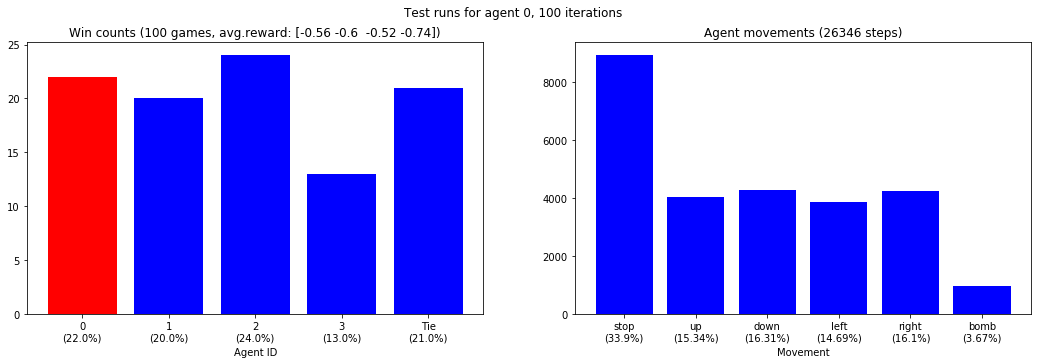

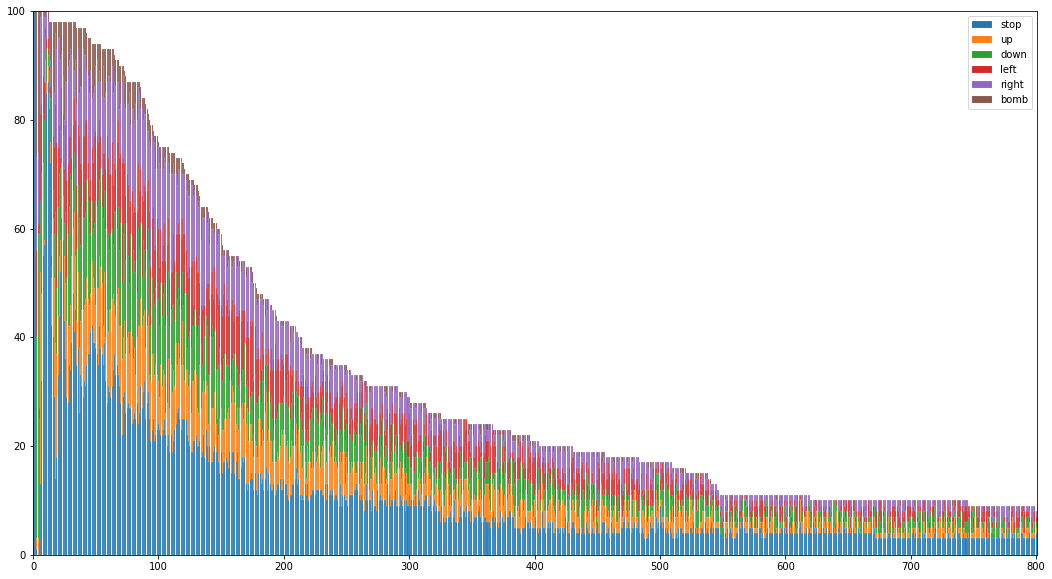

Use SimpleAgent
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


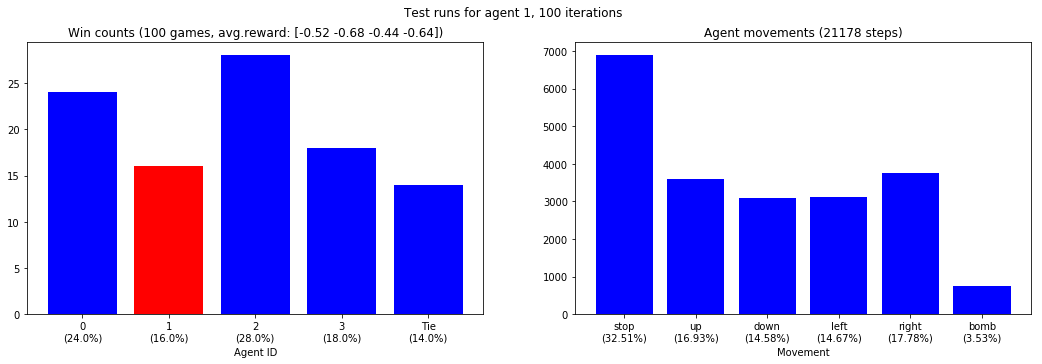

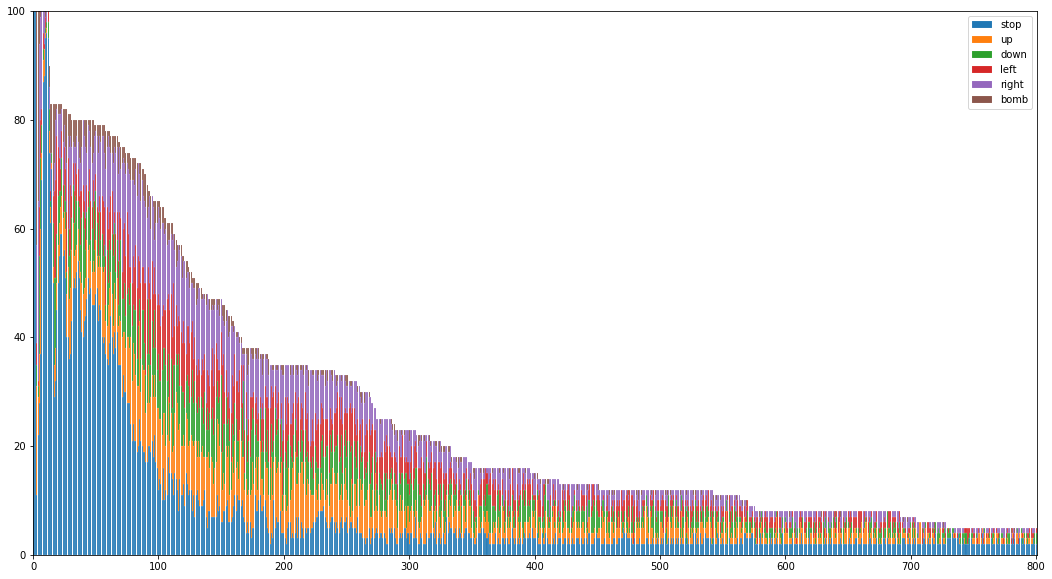

Use SimpleAgent
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


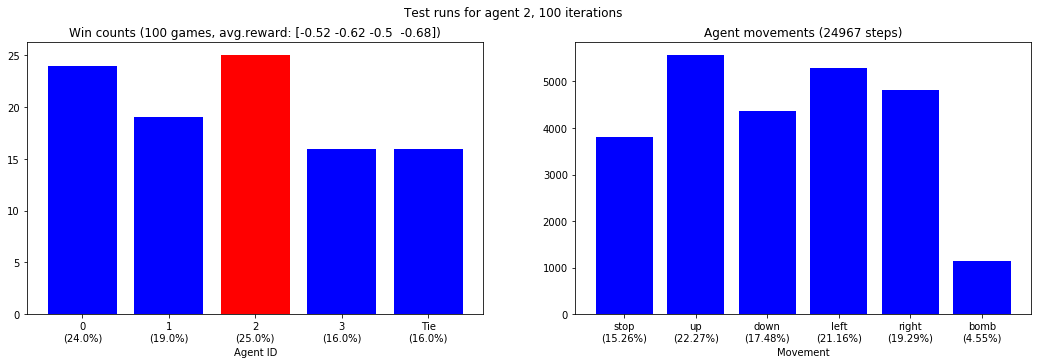

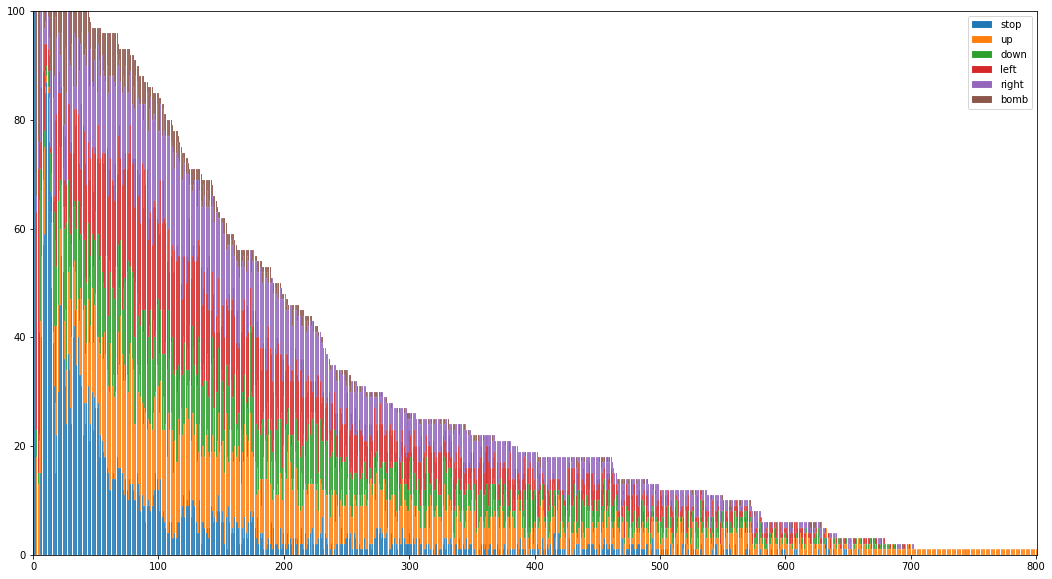

Use SimpleAgent
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


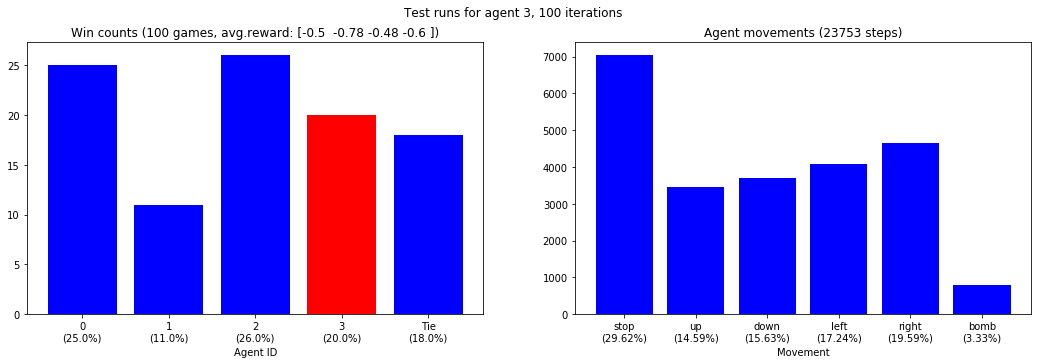

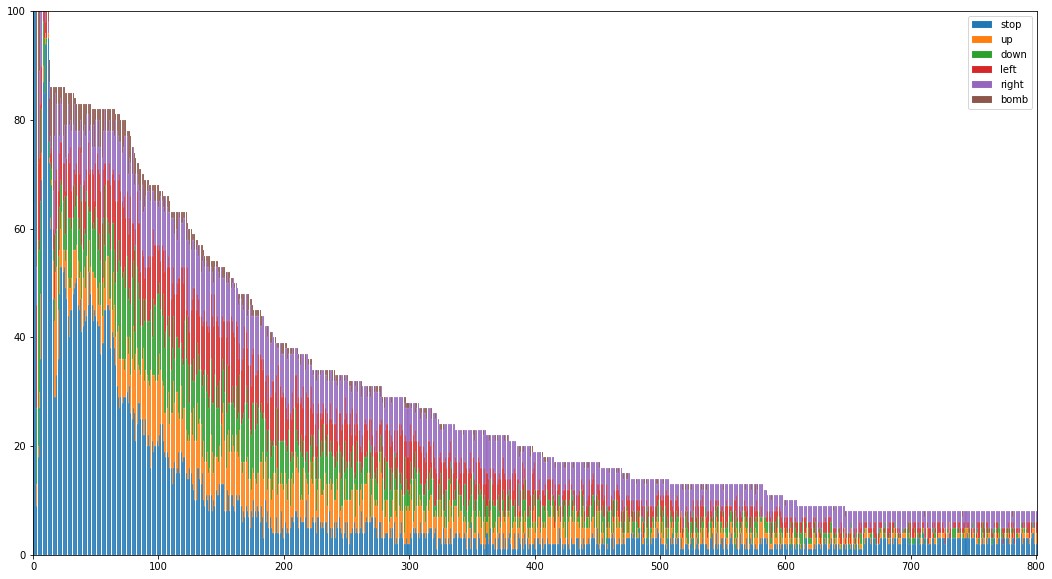

In [5]:
# Evaluate Simple Agent
rewards, lengths, elapsed, total_timesteps, info = evaluate(logs_path='../custom/logs/')

In [ ]:
rewards, lengths, elapsed, total_timesteps, info = evaluate(
    evaluation_model_path='../custom/models/res_rl_2d_8_1M_full_model.hdf5',
    logs_path='../custom/logs/',
    # Set agent properties to preprocess observations
    use_history=False,    # Use previous observations for predictions
    use_2d=True,         # Use 2d convolutions
    patient=True,        # Wait to make initial observations (you don't need it if you don't use history)
    center_view=False,    # Use centering
    original_view=True, # Use 11x11 board, if false, use 21x21
    
    iterations=100, plot=True)

In [ ]:
rewards, lengths, elapsed, total_timesteps, info = evaluate(
    evaluation_model_path='../custom/models/res_rl_2d_8_1M_full_model.hdf5',
    logs_path='../custom/logs/',
    # Set agent properties to preprocess observations
    use_history=False,    # Use previous observations for predictions
    use_2d=True,         # Use 2d convolutions
    patient=True,        # Wait to make initial observations (you don't need it if you don't use history)
    center_view=False,    # Use centering
    original_view=True, # Use 11x11 board, if false, use 21x21
    
    iterations=100, plot=True)

## Compare several models

In [77]:
logs_path = '../custom/logs/' # Here all your test logs are placed

# Provide here names for plots and filenames of models
models = {'SimpleAgent': 'eval_SimpleAgent_100.npz',
          'Imitation\n(ATARI pretraining, 10 epochs)': 'eval_deep_mind_dqn_pretrain_2d_1_full_model_100.npz',
          'Imitation\n(simple transformation)': 'eval_immitation_model_simpletransformation_100_1.npz',
          'Imitation\n(3 res blocks)': 'eval_imit3res_100.npz',
          'Imitation (3 res blocks) + DQN 500k steps': 'eval_res_rl_2d_8_1M_full_model_100.npz',
          'TRPO': 'eval_trpo_100.npz',
          'MCTS': 'eval_MCTS_100.npz',
          'Imitation(ATARI)\n+ DQN 1M steps': 'eval_deep_mind_dqn_rl_2d_8_1M_full_model_100.npz',
          'Imitation(ATARI)\n+ DQN 1M steps\n+ reward shaping 600k steps': 'eval_deep_mind_dqn_rl_2d_8_1M_rs_600k_full_model_100.npz',
          'Imitation(ATARI)\n+ DQN reward shaping 700k steps': 'eval_deep_mind_dqn_rl_2d_700k_rs_full_model_100.npz'}

evals = [np.load(logs_path + models[k]) for k in models.keys()]
n_models = len(evals)
n_models

10

We want to compare the performance of only our agent in a specific corner

In [78]:
rewards = np.array([[k['rewards'][i, :, i].squeeze() for i in range(4)] for k in evals])
lengths = np.array([[k['lengths'][i, :, i].squeeze() for i in range(4)] for k in evals])
rewards.shape

(10, 4, 100)

#### Mean rewards

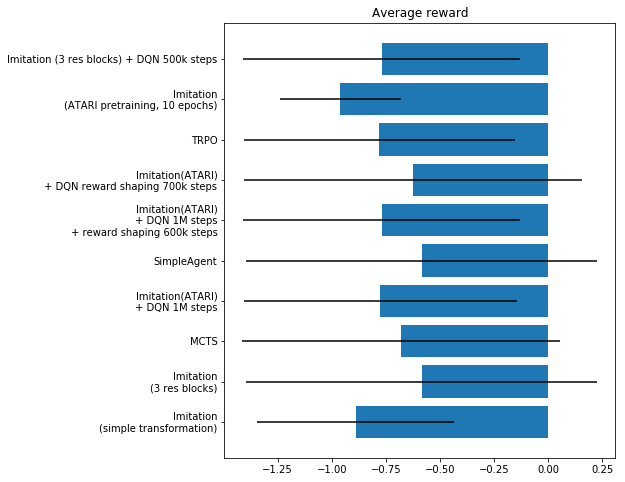

In [80]:
fig = plt.figure(figsize=(7,8))
reward_means = [np.mean(rewards[k]) for k in range(n_models)]
reward_stds = [np.std(rewards[k]) for k in range(n_models)]

plt.barh(range(len(reward_means)), reward_means, xerr=reward_stds)
plt.title("Average reward")
plt.yticks(range(len(reward_means)), models.keys())
plt.show()

#### Mean episode lengths

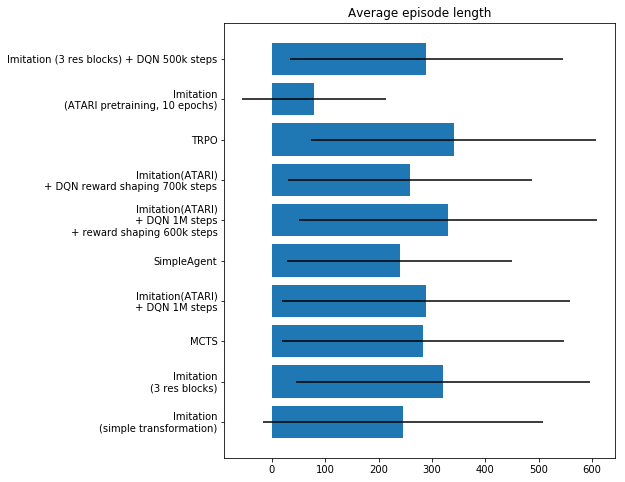

In [81]:
fig = plt.figure(figsize=(7,8))
length_means = [np.mean(lengths[k]) for k in range(n_models)]
length_stds = [np.std(lengths[k]) for k in range(n_models)]

plt.barh(range(len(reward_means)), length_means, xerr=length_stds)
plt.title("Average episode length")
plt.yticks(range(len(length_means)), models.keys())
plt.show()

#### Speed

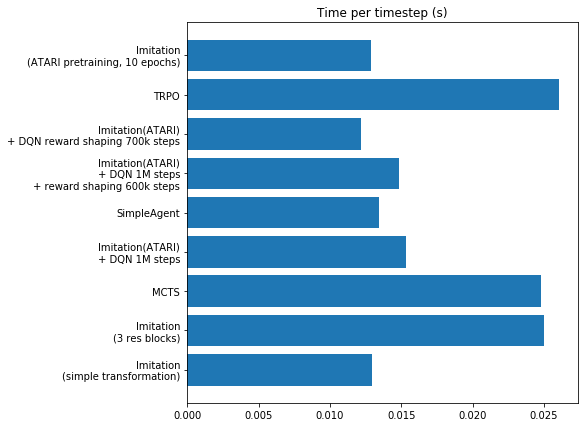

In [74]:
fig = plt.figure(figsize=(7,7))
speeds = [np.sum(evals[k]['elapsed']) / evals[k]['total_timesteps'] for k in range(n_models)]

plt.barh(range(len(speeds)), speeds)
plt.title("Time per timestep (s)")
plt.yticks(range(len(speeds)), models.keys())
plt.show()

#### Rewards in different positions

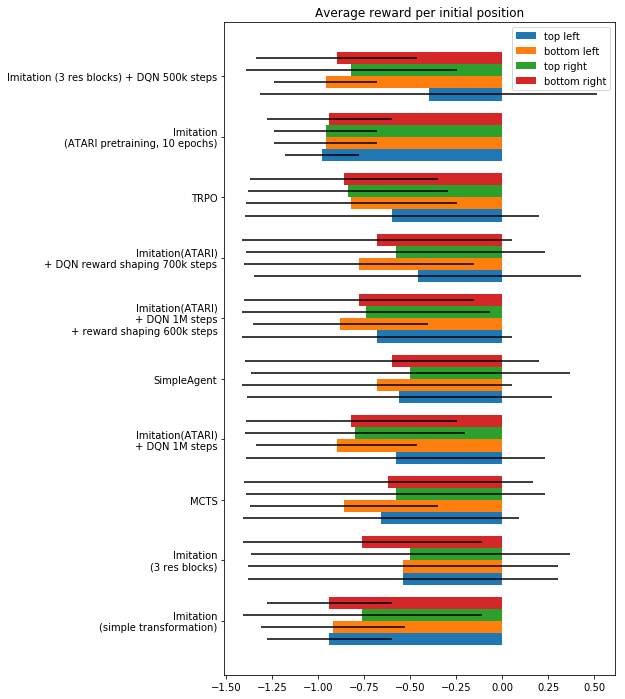

In [82]:
fig = plt.figure(figsize=(7, 12))
reward_means = np.array([np.mean(rewards[k], axis=1) for k in range(n_models)])
reward_stds = np.array([np.std(rewards[k], axis=1) for k in range(n_models)])
width = 0.2
for i in range(4): # corners
    plt.barh(np.arange(n_models) + width * i, reward_means[:, i], xerr=reward_stds[:, i], height=0.2)

plt.title("Average reward per initial position")
plt.yticks(np.arange(n_models) + 0.3, models.keys())
plt.legend(['top left', 'bottom left', 'top right', 'bottom right'], bbox_to_anchor=(1.0, 1.0))
plt.show()

#### Episode lengths in different positions

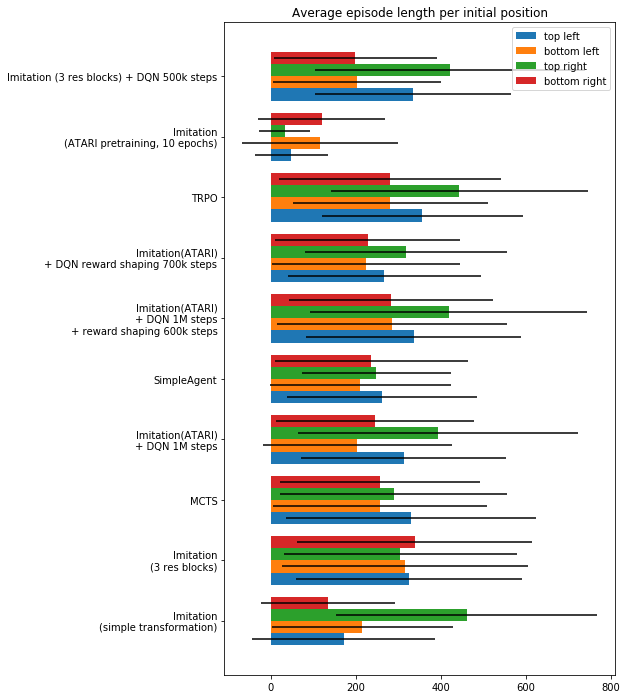

In [83]:
fig = plt.figure(figsize=(7, 12))
length_means = np.array([np.mean(lengths[k], axis=1) for k in range(n_models)])
length_stds = np.array([np.std(lengths[k], axis=1) for k in range(n_models)])

for i in range(4): # corners
    plt.barh(np.arange(n_models) + width * i, length_means[:, i], xerr=length_stds[:, i], height=width)

plt.title("Average episode length per initial position")
plt.yticks(np.arange(n_models) + 0.3, models.keys())
plt.legend(['top left', 'bottom left', 'top right', 'bottom right'], bbox_to_anchor=(1.0, 1.0))
plt.show()